<a href="https://colab.research.google.com/github/paddy-03/Sentiment-Analysis-Amazon-Fine-Food-Reviews/blob/master/Amazon_Food_Reviews_(word2vec_%2B_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import warnings
warnings.filterwarnings("ignore")


import math
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.snowball import SnowballStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import keras
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import BatchNormalization,Dense , Flatten ,Embedding,Input,LSTM
from keras.models import Model
from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout

from tqdm import tqdm
import os

Using TensorFlow backend.


In [0]:
os.chdir('./drive/My Drive/amazon_food_reviews')

In [0]:
sql = sqlite3.connect('database.sqlite')
raw_data = pd.read_sql_query(""" SELECT * FROM Reviews """, sql)


In [0]:
raw_data.shape

(568454, 10)

In [0]:
#filtering all data and rejecting the entries with score 3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews LIMIT 50000""", sql)

#function to label the score, if 4 or 5 score is positive else negetive
def partition(s):
  if s>3:
     return 1
  return 0

filtered_data['Score'] = filtered_data['Score'].map(partition)
filtered_data.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
filtered_data.shape

(50000, 10)

## **Data Cleaning**

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", sql)

In [0]:
display.head()

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display.shape

(80668, 7)

In [0]:
pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text
FROM Reviews
where UserId = '#oc-R11D9D7SHXIJB9'

""", sql)

,UserId,ProductId,ProfileName,Time,Score,Text
0,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u..."
1,#oc-R11D9D7SHXIJB9,B005HG9ERW,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u..."
2,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u..."


**Observation**

Duplicate entries present, although the product ids differ but it's not possible to have multiple entries by a same user at a given timestamp. The different products are basically variations of a single product only, hence as the text too is same, the duplicate entries must be removed.

In [0]:
filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False).shape

(46268, 10)

In [0]:
print('Data left: ',46268*100/50000,'%')

Data left:  92.536 %


In [0]:
filtered_data = filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [0]:
filtered_data['Score'].value_counts()

1    35520
0    10748
Name: Score, dtype: int64

## **Text Preprocessing**

**Tasks to do:**

1. Removing words with HTML tags
2. Removing URLs
3. Converting all words to lowercase
4. Removing all special characters and punctuation marks
5. Removing alpha-numeric words
6. Removing Stopwords
7. Stemming

  

In [0]:
def removeHTMLtags(s):
  comp = re.compile('<.*>')
  return re.sub(comp,'',s)

In [0]:
def removeURLs(s):
  return re.sub(r'http\S+', '', s)

In [0]:
def toLower(s):
   return s.lower()

In [0]:
def removeSpl(s):
  return s.translate(str.maketrans('', '', string.punctuation))

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
def removealphanum(s):
   return re.sub("\S*\d\S*", "", s).strip()

In [0]:
nltk.download('stopwords')
stop = list(set(nltk.corpus.stopwords.words('english')))
ctr = 0
for i in stop:
    print ("'" +i+"'"+', ',end='')
    ctr=ctr+1
    if(ctr==15):
      print()
      ctr=0

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
'll', 'won't', 'wasn't', 'which', 'being', 'over', 'aren't', 'yourselves', 'him', 'before', 'as', 'doesn't', 'do', 'ma', 'her', 
'these', 'through', 'should', 're', 'shan't', 'them', 'd', 'm', 'against', 'this', 'some', 'you'll', 'down', 'isn', 'myself', 
'wouldn', 'mustn't', 'too', 'both', 'you', 'mightn', 'to', 'an', 'hers', 'more', 'haven't', 'he', 't', 'ourselves', 'from', 
'by', 'nor', 'our', 'no', 'she's', 'i', 'any', 'most', 'after', 'itself', 'himself', 'they', 'theirs', 'doing', 'under', 
'further', 'until', 'then', 'his', 'you'd', 'shan', 'a', 'about', 'wasn', 'here', 'your', 'there', 'in', 'or', 'same', 
'been', 'who', 'can', 'had', 'is', 'doesn', 'am', 'few', 'hadn', 'it's', 'are', 'off', 'she', 'wouldn't', 'shouldn', 
'ain', 'having', 'because', 'again', 'mightn't', 'not', 'so', 'have', 'above', 'up', 'of', 'during', 'each', 'between', 'why', 
'won', 'you'

In [0]:
stop.remove('not')
stop.remove('no')
stop.remove('nor')

In [0]:
stemmer = SnowballStemmer('english')
#stemmer.stem('Happiness')

In [0]:
from tqdm import tqdm
preprocessed_reviews = []
labels = []
w2v_doc = []
# tqdm is for printing the status bar
for sentance in tqdm(filtered_data['Text'].values):
    sentance = removeHTMLtags(sentance)
    sentance = removeURLs(sentance)
    sentance = toLower(sentance)
    sentance = removeSpl(sentance)
    sentance = removealphanum(sentance)
    w2v_doc.append(sentance.split())

100%|██████████| 46268/46268 [00:02<00:00, 17252.56it/s]


## **Train-Test Split**

In [0]:
pos_reviews_w2v=[]
neg_reviews_w2v=[]

for i in tqdm(range(46072)):
  if(filtered_data['Score'].values[i]==0):
    neg_reviews_w2v.append(w2v_doc[i])

  else:
    pos_reviews_w2v.append(w2v_doc[i])

100%|██████████| 46072/46072 [00:00<00:00, 219238.85it/s]


In [0]:
from random import shuffle

shuffle(pos_reviews_w2v)
shuffle(neg_reviews_w2v)

In [0]:
#choosing 20000 positive and 20000 negative documents

data_subset_w2v = np.array(pos_reviews_w2v[:34500] + neg_reviews_w2v[:7500])
labels = np.hstack((np.ones(34500),np.zeros(7500)))

In [0]:
from sklearn.model_selection import train_test_split

x_train_w2v, x_test_w2v, w2v_train, w2v_test = train_test_split(data_subset_w2v, labels, test_size = 0.25, random_state = 42)
x_train_w2v = np.array(x_train_w2v)
x_test_w2v = np.array(x_test_w2v)
print(x_train_w2v.shape, w2v_train.shape, x_test_w2v.shape, w2v_test.shape)

(31500,) (31500,) (10500,) (10500,)


In [0]:
np.unique(w2v_train,return_counts=True)

(array([0., 1.]), array([ 5610, 25890]))

### Word2Vec

In [0]:
w2v_model=Word2Vec(data_subset_w2v,window=10,min_count=1,size=50, workers=4)
w2v_model.train(data_subset_w2v,epochs=10,total_examples=len(data_subset_w2v))
print(w2v_model.wv.most_similar('good'))
print('='*50)
print(w2v_model.wv.most_similar('bad'))

[('great', 0.772996187210083), ('terrific', 0.7463681101799011), ('decent', 0.7437984347343445), ('fantastic', 0.7179824113845825), ('bad', 0.6821128129959106), ('amazing', 0.6733249425888062), ('reasonable', 0.6697764992713928), ('nice', 0.6694865822792053), ('biscuity', 0.6572914719581604), ('fine', 0.6489811539649963)]
[('funny', 0.6949297189712524), ('weird', 0.6858431100845337), ('good', 0.6821128129959106), ('nasty', 0.6735140085220337), ('awful', 0.6718595623970032), ('gross', 0.6526566743850708), ('horrible', 0.6334760189056396), ('disgusting', 0.6297018527984619), ('offensive', 0.6242376565933228), ('ok', 0.6203601360321045)]


In [0]:
w2v_model.wv['good']

array([-4.1333857e-01,  7.5791717e-02, -5.9959769e-01,  4.0416355e+00,
        2.5645525e+00, -2.9963005e+00,  3.4601398e+00, -1.6468239e+00,
        1.4670614e+00, -2.3260996e+00, -1.4364648e+00, -1.5926144e+00,
       -2.2471988e+00, -8.8085407e-01,  3.9961944e+00, -1.5639321e+00,
       -9.0524995e-01,  6.1657727e-01, -8.3836132e-01, -2.4887557e-01,
        1.5751072e+00,  2.9418542e+00, -7.9035759e-01, -2.6491981e+00,
       -8.5300982e-01, -4.0585575e+00,  2.0200922e+00,  1.8073987e+00,
        2.2471018e+00,  1.3371334e+00, -1.7829807e-01, -1.4839355e+00,
        3.8258195e+00,  1.1718938e+00,  2.4355638e+00, -1.4830320e+00,
        3.5959423e+00, -6.7586869e-01,  5.3028688e+00, -1.7709090e+00,
        1.4021497e+00, -1.3217939e+00, -4.4466329e-01, -2.2640262e+00,
       -4.6017976e+00,  4.9794436e+00,  1.6029589e+00, -3.4108013e-03,
       -2.1032972e+00, -3.5542114e+00], dtype=float32)

In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 1 time ",len(w2v_words))
print("sample words ", w2v_words[60:100])

number of words that occured minimum 1 time  49742
sample words  ['spoon', 'used', 'measure', 'tastes', 'like', 'very', 'tart', 'wonderful', 'cherry', 'pie', 'despite', 'fact', 'there', 'no', 'added', 'sugar', 'im', 'hoping', 'will', 'help', 'with', 'arthritis', 'we', 'bought', 'these', 'chips', 'at', 'sandwich', 'shop', 'sonoma', 'while', 'on', 'vacation', 'wasnt', 'sure', 'what', 'expect', 'package', 'first', 'bite']


In [0]:
x_train_w2v.shape

(31500,)

In [0]:
tok = Tokenizer()
tok.fit_on_texts(data_subset_w2v)
encd_rev_train = tok.texts_to_sequences(x_train_w2v)
encd_rev_test = tok.texts_to_sequences(x_test_w2v)

In [0]:
maxi = 0
for i in data_subset_w2v:
  if len(i)>maxi:
    maxi = len(i)

maxi

621

In [0]:
max_rev_len= maxi  # max lenght of a review
vocab_size = len(w2v_words)+1
embed_dim= 50 # embedding dimension as choosen in word2vec constructor

In [0]:
pad_rev_train = pad_sequences(encd_rev_train, maxlen=max_rev_len, padding='pre')
pad_rev_test = pad_sequences(encd_rev_test, maxlen=max_rev_len, padding='pre')
pad_rev_train.shape 

(31500, 621)

In [0]:
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.word_index.items():
  embed_vector=w2v_model.wv[word]
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero.

In [0]:
embed_matrix.shape

(49743, 50)

In [0]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len,embeddings_initializer=Constant(embed_matrix)))
model.add(BatchNormalization())
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False))
#model.add(Flatten())
#model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 621, 50)           2487150   
_________________________________________________________________
batch_normalization_1 (Batch (None, 621, 50)           200       
_________________________________________________________________
lstm_1 (LSTM)                (None, 621, 100)          60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 621, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [0]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3),loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
epochs=5
batch_size=100

In [0]:
model.fit(pad_rev_train,w2v_train,epochs=epochs,batch_size=batch_size,validation_data=(pad_rev_test,w2v_test))

Train on 31500 samples, validate on 10500 samples
Epoch 1/5
31500/31500 [==============================] - 788s 25ms/step - loss: 0.3487 - acc: 0.8489 - val_loss: 0.3127 - val_acc: 0.8664
Epoch 2/5
31500/31500 [==============================] - 787s 25ms/step - loss: 0.2773 - acc: 0.8810 - val_loss: 0.2719 - val_acc: 0.8860
Epoch 3/5
31500/31500 [==============================] - 775s 25ms/step - loss: 0.2359 - acc: 0.9040 - val_loss: 0.2580 - val_acc: 0.8910
Epoch 4/5
31500/31500 [==============================] - 772s 24ms/step - loss: 0.2059 - acc: 0.9163 - val_loss: 0.2581 - val_acc: 0.8904
Epoch 5/5
31500/31500 [==============================] - 776s 25ms/step - loss: 0.1819 - acc: 0.9269 - val_loss: 0.2662 - val_acc: 0.8981


In [0]:
model.save('amzlstm1.h5')

In [0]:
w2v_pred = model.predict_classes(pad_rev_test)

In [0]:
w2v_pred

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]], dtype=int32)

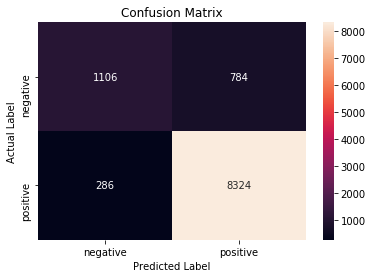

In [0]:
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(w2v_test, w2v_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [0]:
from sklearn.metrics import classification_report
print(classification_report(w2v_test, w2v_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.59      0.67      1890
         1.0       0.91      0.97      0.94      8610

    accuracy                           0.90     10500
   macro avg       0.85      0.78      0.81     10500
weighted avg       0.89      0.90      0.89     10500



In [0]:
w2v_conf = model.predict(pad_rev_test)

In [0]:
from sklearn.metrics import roc_auc_score
fpr, tpr, threshold = roc_curve(w2v_test,w2v_conf,pos_label=1)
roc_auc = auc(fpr, tpr)
roc_auc

0.9258933564392333

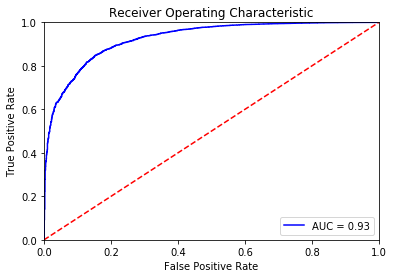

In [0]:
plt.figure(figsize=(6,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()